## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [1]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

zsh:1: command not found: gdown


In [3]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=7e3eab16-959c-458e-ae16-ae832231e96e
To: /Users/rhythmaggarwal/Desktop/ML/SMAI_24/rollnumber_A1/rollnumber_A1_Q2/coco_captions.npy
100%|████████████████████████████████████████| 415M/415M [01:10<00:00, 5.90MB/s]


In [4]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
# !pip install faiss-cpu

--2024-01-22 13:17:46--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.113.169, 3.5.3.196, 3.5.24.210, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.113.169|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  4.76MB/s    in 30m 53s 

2024-01-22 13:48:39 (3.42 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]

unzip:  cannot find or open /content/val2014.zip, /content/val2014.zip.zip or /content/val2014.zip.ZIP.
--2024-01-22 13:48:40--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.162.251, 52.216.93.35, 52.217.116.25, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.162.251|:80... connected.
HTTP request sent, awaiting response... 200 OK


In [1]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import matplotlib.pyplot as plt
import faiss
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import time

In [2]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = './content/val2014',
                        annFile = './content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [3]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [4]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [5]:
cap_path = 'coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [6]:
img_path = 'coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [7]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

In [8]:
d = 512 
index = faiss.IndexFlatL2(d)  # L2 distance index

In [9]:
index.add(image_embeddings)

In [10]:
def FAISS_knn(k = 1):
    distances, indices = index.search(image_embeddings, k+1)
    distances = distances[:,1:]
    similarity = 1 - distances
    indices = indices[:,1:]
    nearest_captions = np.vectorize(lambda index: caption_embeddings[index], signature='(n)->(n,k,m)')(indices)
    
    def image_caption_query(index):
        return (similarity[index] @ np.sum(nearest_captions[index], axis = 1)) / (5*k)

    image_caption_queries = np.vectorize(image_caption_query, signature='()->(n)')(np.arange(len(coco_dset)))
    
    predicted_captions = []
    
    def calc_cosine(index):
        caption_query_similarity = nearest_captions[index] @ image_caption_queries[index]
        max_index = np.argmax(caption_query_similarity)
        max_index = np.unravel_index(max_index, caption_query_similarity.shape)
        caption = captions_np[indices[index][max_index[0]]][max_index[1]]
        predicted_captions.append(caption)
    
    _ = np.vectorize(calc_cosine)(np.arange(len(coco_dset)))
    return predicted_captions[1:]

## Trying different k

In [11]:
accuracies = []
for k in range(1,10):
    curr = time.time()
    predicted_captions = FAISS_knn(k)
    
    accuracies.append(accuracy_v2(predicted_captions, captions_np))
    print(f"{k} - {time.time()-curr}")

1 - 11.219258069992065
2 - 11.391952991485596
3 - 11.540452003479004
4 - 12.272198915481567
5 - 12.449162006378174
6 - 12.870707988739014
7 - 13.958022117614746
8 - 13.49409794807434
9 - 14.835155963897705


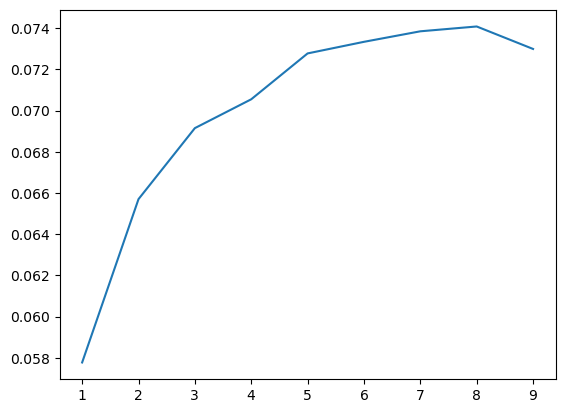

In [12]:
plt.plot(range(1,10), accuracies)

We select k = 8 since it gives the maximum Accuracy as shown above

## Running for k = 8 with different FAISS indexes

In [13]:
# L2 distance index
index = faiss.IndexFlatL2(d)
index.add(image_embeddings)
curr = time.time()
predicted_captions_l2 = FAISS_knn(k = 8)
time_taken = time.time() - curr
acc = accuracy_v2(predicted_captions_l2, captions_np)
print(f"L2 index: acc = {acc}, time = {time_taken}")


# Inner Product
index = faiss.IndexFlatIP(d)
norms = np.linalg.norm(image_embeddings, axis=1, keepdims=True)
normalised_image_embeddings = image_embeddings / norms
index.add(normalised_image_embeddings)
curr = time.time()
predicted_captions = FAISS_knn(k = 8)
time_taken = time.time() - curr
acc = accuracy_v2(predicted_captions, captions_np)
print(f"Inner Product index: acc = {acc}, time = {time_taken}")

# L2 distance index using cluster optimization
clusters = 100
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, clusters, faiss.METRIC_L2)
index.train(image_embeddings)
index.add(image_embeddings)
curr = time.time()
predicted_captions = FAISS_knn(k = 8)
time_taken = time.time() - curr
acc = accuracy_v2(predicted_captions, captions_np)
print(f"L2 index (clusters): acc = {acc}, time = {time_taken}")

# Inner Product distance index using cluster optimization
clusters = 100
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, clusters, faiss.METRIC_INNER_PRODUCT)
norms = np.linalg.norm(image_embeddings, axis=1, keepdims=True)
normalised_image_embeddings = image_embeddings / norms
index.train(normalised_image_embeddings)
index.add(normalised_image_embeddings)
curr = time.time()
predicted_captions = FAISS_knn(k = 8)
time_taken = time.time() - curr
acc = accuracy_v2(predicted_captions, captions_np)
print(f"Inner Product index (clusters): acc = {acc}, time = {time_taken}")


L2 index: acc = 0.07408762191500541, time = 8.98133397102356
Inner Product index: acc = 0.07254529345103992, time = 8.81279993057251
L2 index (clusters): acc = 0.0696089412777258, time = 3.2575948238372803
Inner Product index (clusters): acc = 0.06780080497502258, time = 3.1421189308166504


## Visualising Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


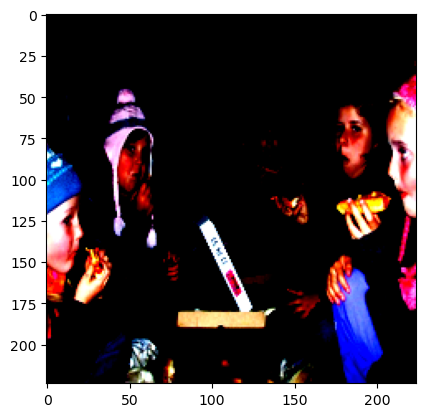

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Captions:
['A group of friends sitting around a table eating pizza.', 'People are sitting outside eating pizza from a box.', 'Several children with slices of pizza in their hands.', 'A group of girls eat a pizza outside at night.', 'Group of people sitting at a table eating pizza out of a box. ']
Generated Caption:
The young girl is happily eating a slice of pizza.





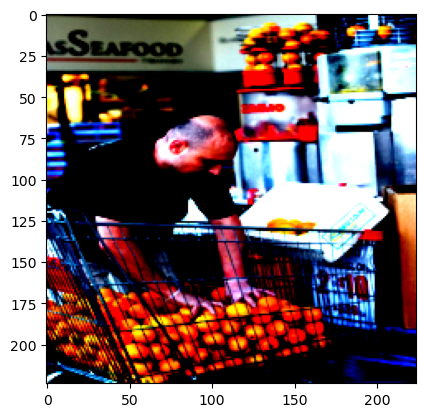

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Captions:
['A man unloading a basket filled with lots of oranges.', 'A man sorting oranges in a shopping cart.', 'A store clerk gathering oranges from a shopping cart to fill a display box.', 'A man taking out oranges from a trolley  in a store', 'a man reachiing in to a basket filled with oranges']
Generated Caption:
There is a display of different kinds of fruit





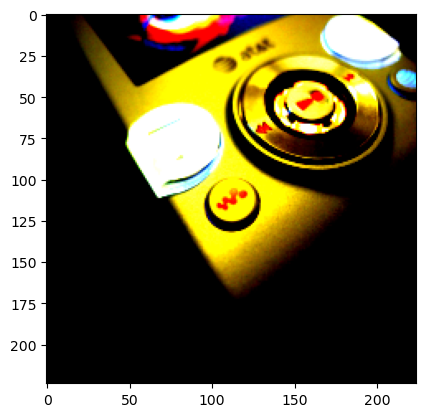

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Captions:
['Closeup of a cellphone device with various buttons.', 'A close up photo of a smart phone lit up.', 'A close-up image of a multi media device.', 'Some control buttons on an orange and silver electronic device.', 'A small cell phone on a dark surface.']
Generated Caption:
A keyboard with several outer buttons as options on it.





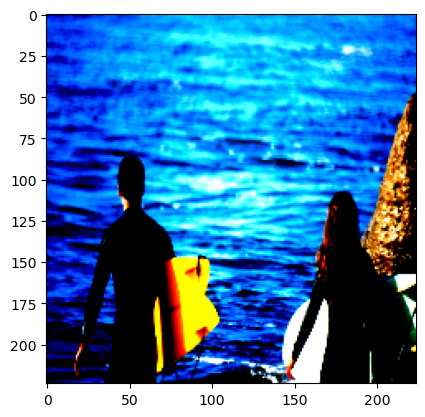

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Captions:
['A man and woman holding surfboards close to the sea', 'A couple of people with surfboards walking towards the water.', 'a body of water that has some surfers on it', 'a man and woman in wet suits carrying surf boards', 'two people in wet suits walking towards the water ']
Generated Caption:
A person on a surfboard in the water.





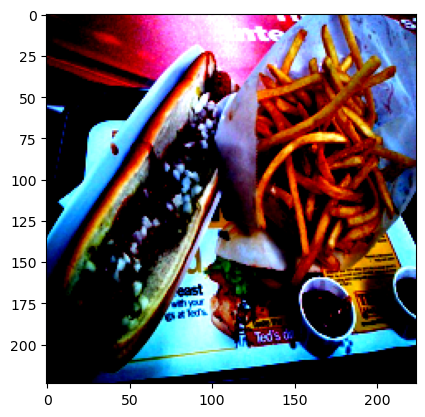

Actual Captions:
['A foot long hot dog next to a pile of fries.', 'A foot long hotdog and fries are on a tray.', 'A long hot dog and french fries are on a plate.', 'Foot long hotdog with condiments, fries and ketchup on a plastic tray', 'A hotdog and fries sit upon a tray.']
Generated Caption:
a hotdog with cheese, with a side of chili fries





In [14]:
random_images_index = np.random.choice(range(len(captions)), 5, replace = False)
for index in random_images_index:
    image = np.transpose(coco_dset[index][0], [1,2,0])
    plt.imshow(image)
    plt.show()
    print(f"\033[1mActual Captions\033[0m:\n{coco_dset[index][1]}")
    print(f"\033[1mGenerated Caption\033[0m:\n{predicted_captions_l2[index]}")
    print("\n\n")